In [1]:
# -- initialize object resources manager
from igni.mdbutil import NodeProperties
from squaternion import Quaternion
from igni.resources import ResourceManager, ResourceTypes
from igni.mdb2fbx import Material
from igni.mdbutil import get_all_nodes, get_all_bones, get_all_animated_nodes
from igni.mdb import Mdb

resource_manager = ResourceManager("E:/projects/the_witcher/content_pipeline/unbiffed/")
all_mdbs = resource_manager.get_all_of_type((ResourceTypes.MDB))

# -- utility for getting mdb by name
def get_mdb(mdb_name):
    resources = [resource for resource in all_mdbs if mdb_name in resource.file.name]
    return [rcs.get() for rcs in resources]

    '''
    if len(resources) == 0:
        raise Exception('zero models found')
    elif len(resources) > 1:
        raise Exception('more than one qualifying model found')
    else:
        return resources[0].get()
    '''

In [2]:
from scipy.spatial.transform import Rotation
import numpy as np

def has_parent(node):
    parent_ptr = node.parent_node
    return parent_ptr.offset != 0

def get_all_parent_transforms(node):
    
    transforms = []
    
    current_node = node
    
    def get_node_transform(node):
        node_properties: NodeProperties = NodeProperties.from_node(node)
        if node_properties.location is not None and node_properties.rotation is not None:
            return node_properties.location.value, node_properties.rotation.value
    
    transform = get_node_transform(current_node)
    if transform is not None:
        transforms.append(transform)
    
    while has_parent(current_node):
        current_node = current_node.parent_node.data
        transform = get_node_transform(current_node)
        if transform is not None:
            transforms.append(get_node_transform(current_node))
    
    return transforms

def apply_all_transforms_with_quaternion(vector, transforms):
    result = vector
    
    for transform in transforms:
        loc = transform[0]
        rot = transform[1]
        if rot != (0.0, 0.0, 0.0, 0.0):
            quat = Rotation.from_quat(rot)
            try:
                result = quat.apply(np.array(result))
                result = tuple([x for x in result]) # back to tuple...
            except Exception as e:
                print(quat)
                print(result)
        result = tuple([loc[i] + result[i] for i in range(0,3)])
        
    return result

def get_data_for_display(mdb: Mdb):
    data = {}
    
    nodes = get_all_nodes(mdb)
    
    for node in nodes:
        nd: Mdb.Node = node
        
        data[nd.node_name.string] = {'data': []}
        data[nd.node_name.string]['type'] = nd.node_type.name
        
        node_transforms = get_all_parent_transforms(nd)
        
        if nd.node_type == Mdb.NodeType.trimesh or nd.node_type == Mdb.NodeType.skin:
            data[nd.node_name.string]['data'] = [apply_all_transforms_with_quaternion(tuple([vertex.x, vertex.y, vertex.z]), node_transforms) for vertex in nd.node_data.vertices.data]
        elif nd.node_type == Mdb.NodeType.node:
            data[nd.node_name.string]['data'] = [apply_all_transforms_with_quaternion(tuple([0.0, 0.0, 0.0]), node_transforms)]
            
    return data

In [3]:
drown = get_mdb('drown1')
rienc = get_mdb('rienc1')

In [4]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.figsize'] = [25, 25]

def display(data_to_display):
    fig, axis = plt.subplots(2, 2)
    
    left = axis[0,0]
    right = axis[0,1]
    front = axis[1,0]
    top = axis[1,1]
    
    plt.style.use('dark_background')
    [axis.set_aspect('equal') for axis in [left, right, front, top]]

    
    def do_scatter(data, type_):
        marker = '.'
        if type_ == 'node':
            marker = 'x'
        
        size = 1.0
        if type_ == 'node':
            size = 50.0
            
        color = 'blue'
        if type_ == 'node':
            color = 'white'
            
        left.scatter(x=[coord[1] for coord in data], y = [coord[2] for coord in data], marker=marker, s=size, c=color)
        right.scatter(x=[-coord[1] for coord in data], y = [coord[2] for coord in data], marker=marker, s=size, c=color)
        top.scatter(x=[coord[1] for coord in data], y = [coord[0] for coord in data], marker=marker, s=size, c=color)
        front.scatter(x=[coord[0] for coord in data], y = [coord[2] for coord in data], marker=marker, s=size, c=color)
    
    meshes = []
    bones = []
    
    for name, data in data_to_display.items():
        
        if 'shadow' in name:
            continue
            
        if data['type'] == 'trimesh' or data['type'] == 'skin':
            meshes.append({'type': 'trimesh', 'data': data['data']})
        
        elif data['type'] == 'node':
            bones.append({'type': 'node', 'data': data['data']})
            
    for mesh in meshes:
        do_scatter(mesh['data'], mesh['type'])
        
    for bone in bones:
        do_scatter(bone['data'], bone['type'])

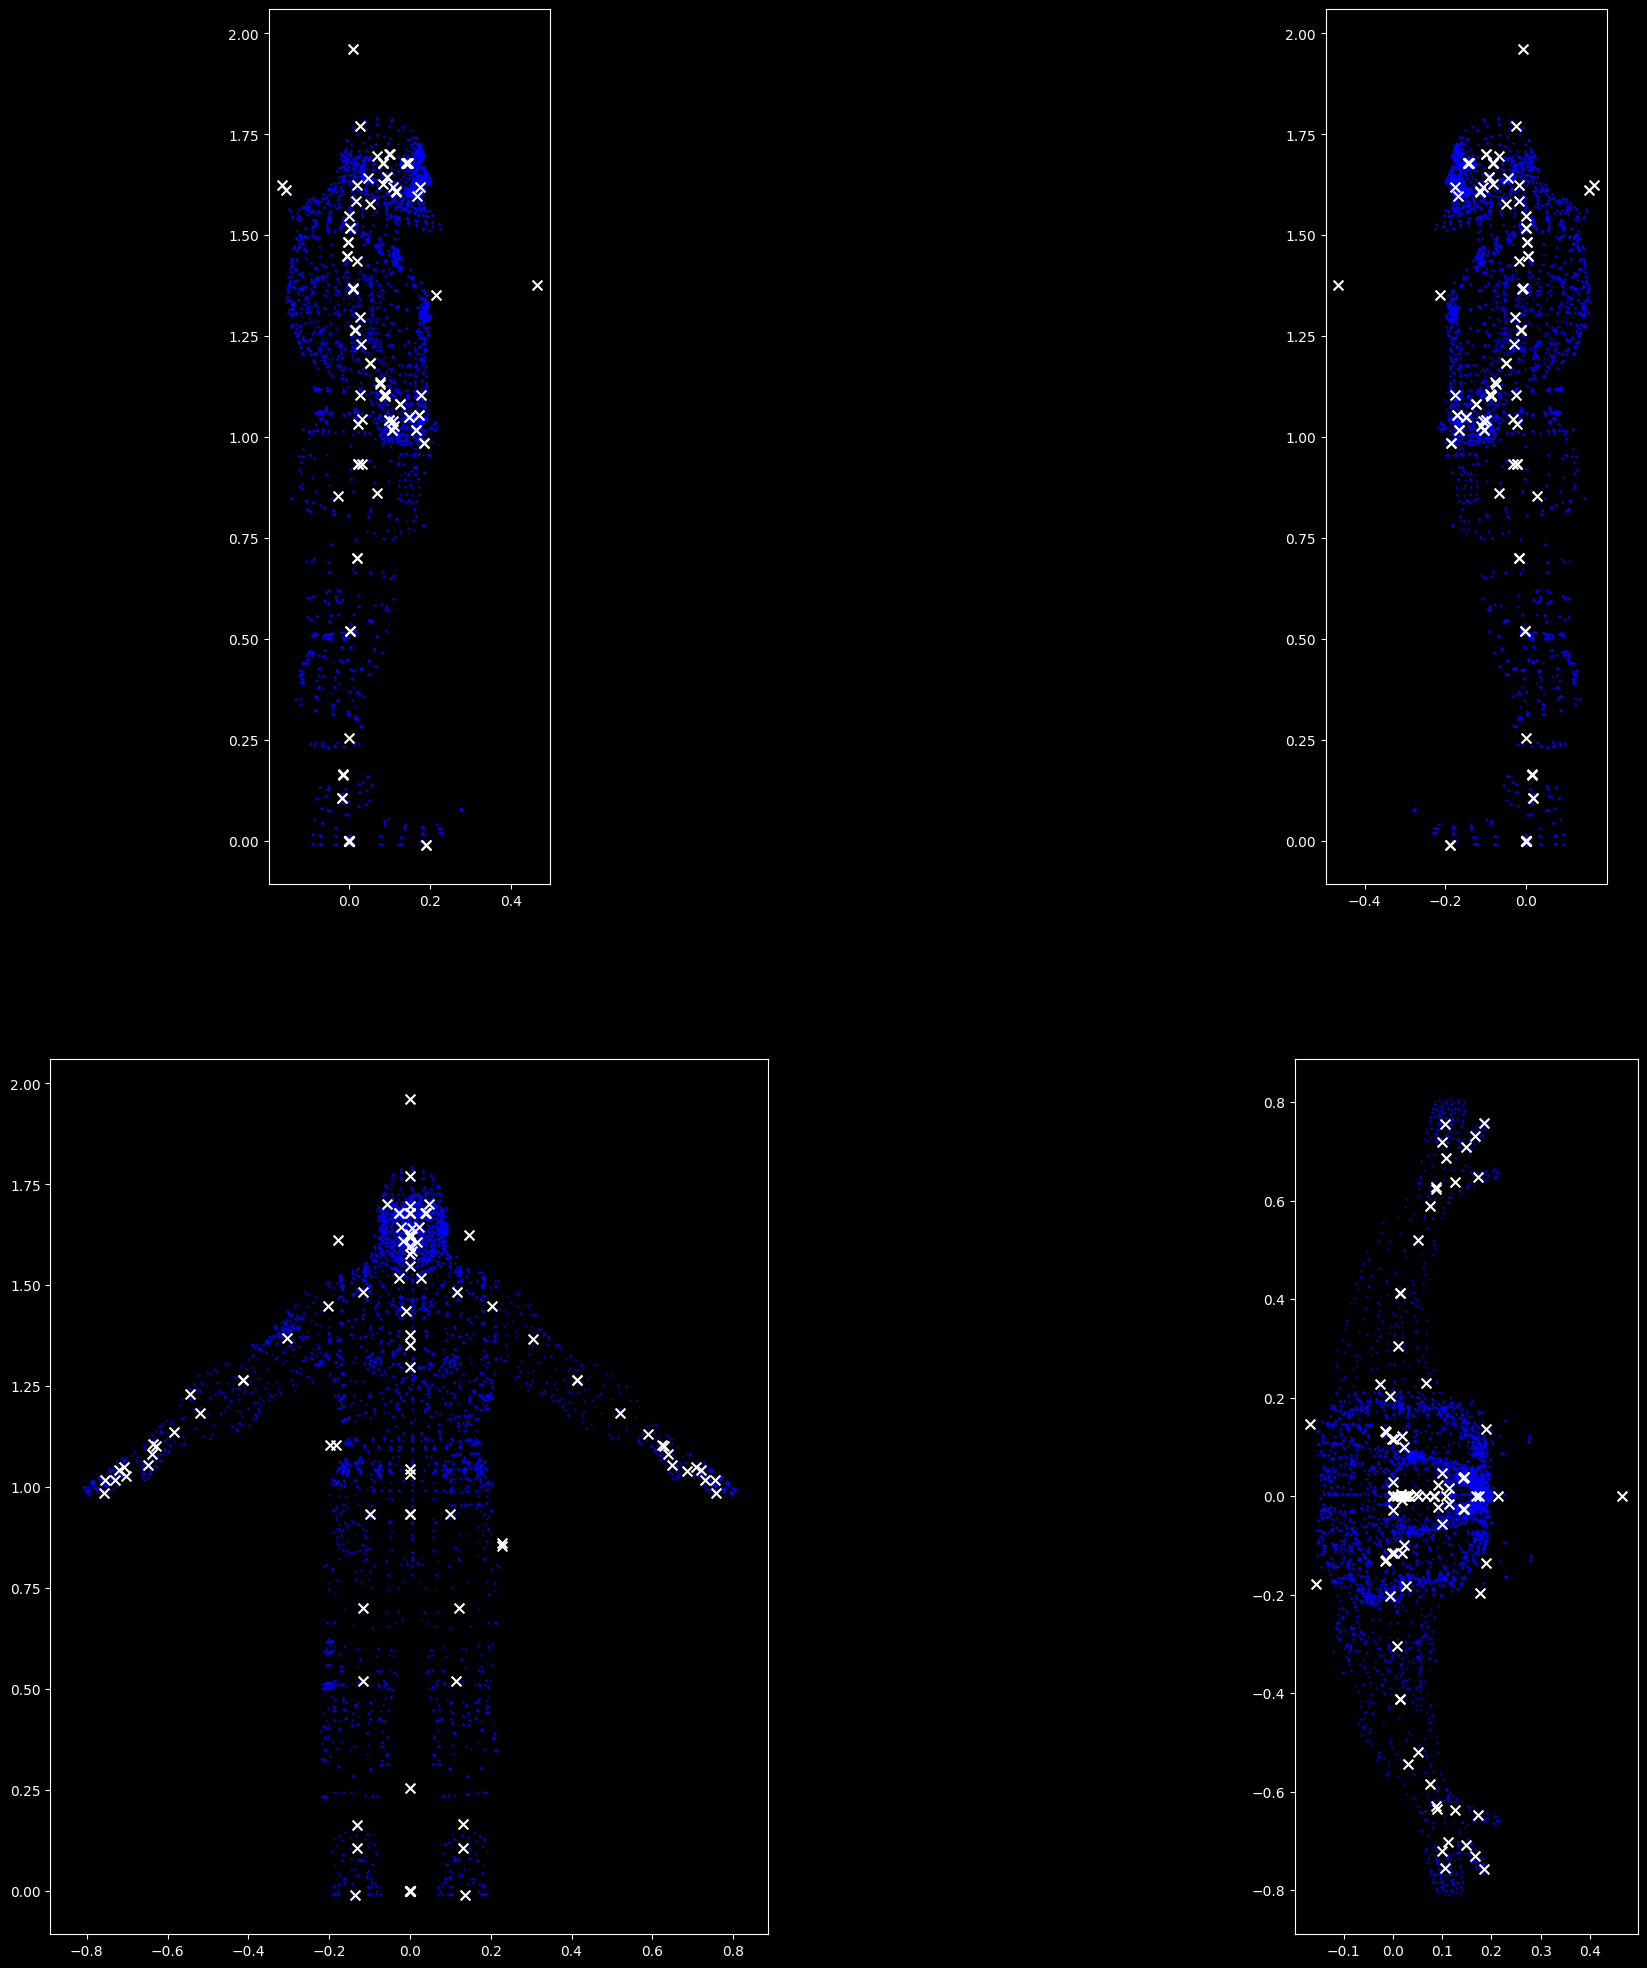

In [6]:
display(get_data_for_display(rienc))

In [5]:
print(len(get_all_nodes(rienc)))
print(len(get_all_bones(rienc)))
print(len(get_all_animated_nodes(rienc)))

127
50
127


In [11]:
gl42 = get_mdb('gl42')
gl42 = gl42[2]

In [17]:
dir([nd for nd in get_all_nodes(gl42)][0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_io',
 '_parent',
 '_read',
 '_root',
 'children',
 'close',
 'controller_data',
 'controller_defs',
 'fixed_rot_impostor_group',
 'flags_type',
 'from_bytes',
 'from_file',
 'from_io',
 'function_pointers',
 'inherit_color_flag',
 'max_lod',
 'min_lod',
 'node_id',
 'node_name',
 'node_type',
 'parent_geometry',
 'parent_node']

In [20]:
[[nd.node_name.string, str(Material(nd.node_data.material.data))] for nd in get_all_nodes(gl42) if nd.node_type == Mdb.NodeType.trimesh]

[['sciana',
  "{'shader': '', 'textures': {}, 'bumpmaps': {}, 'properties': {}}"],
 ['sciana',
  "{'shader': '', 'textures': {}, 'bumpmaps': {}, 'properties': {}}"],
 ['sciana',
  "{'shader': '', 'textures': {}, 'bumpmaps': {}, 'properties': {}}"],
 ['sciana',
  "{'shader': '', 'textures': {}, 'bumpmaps': {}, 'properties': {}}"],
 ['sciana',
  "{'shader': '', 'textures': {}, 'bumpmaps': {}, 'properties': {}}"],
 ['sciana',
  "{'shader': '', 'textures': {}, 'bumpmaps': {}, 'properties': {}}"],
 ['sciana',
  "{'shader': '', 'textures': {}, 'bumpmaps': {}, 'properties': {}}"],
 ['sciana',
  "{'shader': '', 'textures': {}, 'bumpmaps': {}, 'properties': {}}"],
 ['sciana',
  "{'shader': '', 'textures': {}, 'bumpmaps': {}, 'properties': {}}"],
 ['Woda',
  "{'shader': 'swamp_rtref', 'textures': {'leaves_texture': 'fx_bagno', 'bump_texture': 'oceanBump4', 'lightmap': 'Lightmap'}, 'bumpmaps': {}, 'properties': {'fresnel_params': ('0.3', '5.0', '0.1', '0.8'), 'bump_density': '20.0', 'wave_amplitu

In [12]:
day_night_strings = {}
for resource in all_mdbs:
    mdb = resource.get()
    all_nodes = get_all_nodes(mdb)
    all_meshes = [node for node in all_nodes if node.node_type in {Mdb.NodeType.trimesh, Mdb.NodeType.skin}]
    for mesh in all_meshes:
        d_n_string = mesh.node_data.day_night_transition_string.string
        if d_n_string in day_night_strings:
            day_night_strings[d_n_string].append(tuple([mesh.node_name.string, resource.file.full_file_name, mesh.node_data.light_map_name.string, resource.file.size/1000.0]))
        else:
            day_night_strings[d_n_string] = []
            
{key: val for key, val in day_night_strings.items() if len(val) > 1 and len(val) < 141}
list(day_night_strings.keys())

['0:00-NULL',
 '6:00-%s!n;7:00-%s!r;10:00-%s!r;11:00-%s!p;16:00-%s!p;17:00-%s!w;21:00-%s!w;22:00-%s!n',
 '6:00-%s!n;7:00-%s!r;8:00-%s!r;9:00-%s!p;18:00-%s!p;19:00-%s!w;20:00-%s!w;21:00-%s!n',
 '6:00-%s!n;7:00-%s!d;20:00-%s!d;21:00-%s!n;',
 '6:00-nk;7:00-d;20:00-d;21:00-nk',
 '6:00-n;7:00-d;20:00-d;21:00-n',
 '6:00-n;7:00-r;8:00-r;9:00-d;18:00-d;19:00-w;20:00-w;21:00-n',
 '6:00-n;7:00-p;20:00-p;21:00-n;',
 '6:00-n;7:00-d;20:00-d;21:00-n;',
 'X;7:00-%s!r;8:00-%s!r;9:00-%s!p;18:00-%s!p;19:00-%s!w;20:00-%s!w;21:00-%s!n',
 '6:00-%s',
 '6:00-l08n;7:00-l08r;8:00-l08r;9:00-l08d;18:00-l08d;19:00-l08w;20:00-l08w;21:00-l08n']

In [13]:
nd = [nd for nd in get_all_nodes(all_mdbs[165].get()) if nd.node_type in {Mdb.NodeType.trimesh, Mdb.NodeType.skin}][0]
nd2 = [nd for nd in get_all_nodes(all_mdbs[165].get()) if nd.node_type in {Mdb.NodeType.trimesh, Mdb.NodeType.skin}][0]
mat = Material.from_node(nd)
mat2 = Material.from_node(nd2)
mat == mat2
dict(mat) == dict(mat2)

True

In [3]:
str(mat)

"{'shader': 'selfilum', 'textures': {'texture0': 'fx_grease_015', 'self_ilum': 'fx_grease_015_s'}, 'bumpmaps': {}, 'properties': {}, 'texture_strings': [], 'light_map_name': '', 'day_night_light_maps': {}, 'day_night_transition_string': '6:00-%s!n;7:00-%s!r;8:00-%s!r;9:00-%s!p;18:00-%s!p;19:00-%s!w;20:00-%s!w;21:00-%s!n'}"

In [4]:
dict(mat)

{'shader': 'selfilum',
 'textures': {'texture0': 'fx_grease_015', 'self_ilum': 'fx_grease_015_s'},
 'bumpmaps': {},
 'properties': {},
 'texture_strings': [],
 'light_map_name': '',
 'day_night_light_maps': {},
 'day_night_transition_string': '6:00-%s!n;7:00-%s!r;8:00-%s!r;9:00-%s!p;18:00-%s!p;19:00-%s!w;20:00-%s!w;21:00-%s!n'}

In [5]:
mat2 =  Material.from_node([nd for nd in get_all_nodes(all_mdbs[165].get()) if nd.node_type in {Mdb.NodeType.trimesh, Mdb.NodeType.skin}][0])

In [9]:
mat == mat2

True

In [7]:
mat.host_node == mat2.host_node

False

In [10]:
mat.is_empty()

False